In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import time
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize

differential drive kinematics model equations

In [2]:
# Define process model
def kinematics_model(q,t,u):
    # arguments
    #  y   = outputs
    #  t   = time
    #  u   = input value
    #  K   = process gain
    #  tau = process time constant
    x = q[0]
    y = q[1]
    theta = q[2]

    v = u[0]
    w = u[1]

    # calculate derivative
    dxdt = v*np.cos(theta)
    dydt = v*np.sin(theta)
    dthetadt = w

    dqdt = [dxdt,dydt,dthetadt]

    return dqdt

simulate

In [3]:
# time points
t = np.arange(0, 40, 0.1)

#fake inputs
# u = [v(t),
#      w(t)]
u = np.zeros((2,len(t)))
u[0,100:]=0.4
u[1,200:]=0.15
u[1,300:]=-0.15

In [4]:
# initial conditions
q0 = [0,0,0]

# store solution
x = np.empty_like(t)
y = np.empty_like(t)
theta = np.empty_like(t)

# record initial conditions
x[0] = q0[0]
y[0] = q0[1]
theta[0] = q0[2]

# solve ODE
for i in range(1,len(t)):
    # span for next time step
    tspan = [t[i-1],t[i]]
    # solve for next step
    q_t = odeint(kinematics_model,q0,tspan,args=(u[:,i],))
    # store solution for plotting
    x[i] = q_t[1][0]
    y[i] = q_t[1][1]
    theta[i] = q_t[1][2]
    # next initial condition
    q0 = q_t[1]

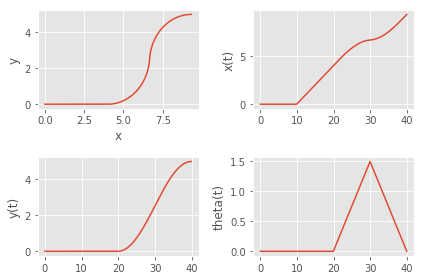

In [5]:

# plot results
# plt.plot(t,u,'g:',label='u(t)')
# plt.plot(t,x,'b-',label='x(t)')
# plt.plot(t,y,'r--',label='y(t)')

#plot trajectory
plt.subplot(2, 2, 1)
plt.plot(x,y)
plt.ylabel('y')
plt.xlabel('x')

#plot x(t)
plt.subplot(2, 2, 2)
plt.plot(t,x)
plt.ylabel('x(t)')
#plt.xlabel('time')


#plot y(t)
plt.subplot(2, 2, 3)
plt.plot(t,y)
plt.ylabel('y(t)')
#plt.xlabel('time')

#plot theta(t)
plt.subplot(2, 2, 4)
plt.plot(t,theta)
plt.ylabel('theta(t)')
#plt.xlabel('time')
#plt.legend(loc='best')

plt.tight_layout()
plt.show()

preliminaries:
* path - > waypoints
* error computation -> cte

In [24]:
def calc_target_index(state,path):
    """
    Finds the index of the closest waypoint.

    :param state: array_like, state of the vehicle [x_pos, y_pos, theta]
    :param path: array_like, reference path ((x1, x2, ...), (y1, y2, ...)]
    :returns: (int,float), nearest_index and cross track error
    """

    if np.shape(state)[0] is not 3 or np.shape(path)[0] is not 2:
        raise ValueError("Input has wrong shape!")

    # Search nearest point index by finding the point closest to the vehicle
    # dx = [state[0] - icx for icx in path[0,:]]
    # dy = [state[1] - icy for icy in path[1,:]]
    # dist = [np.sqrt(idx ** 2 + idy ** 2) for (idx, idy) in zip(dx, dy)]
    dx = state[0]-path[0,:]
    dy = state[1]-path[1,:]
    dist = np.sqrt(dx**2 + dy**2)
    #nn_idx = dist.index(min(dist))
    nn_idx = np.argmin(dist)

    try:

        # versor v from nearest wp -> next wp
        v = [path[0,nn_idx+1] - path[0,nn_idx],
             path[1,nn_idx+1] - path[1,nn_idx]]   
        v /= np.linalg.norm(v)

        # vector d from car position -> nearest wp
        d = [path[0,nn_idx] - state[0],
             path[1,nn_idx] - state[1]]

        # Get the scalar projection of d on v to compare direction
        if np.dot(d,v) > 0:
            target_idx = nn_idx
        else:
            target_idx = nn_idx+1

    except IndexError as e:
        target_idx = nn_idx

    front_axle_vect = [np.cos(state[2] - np.pi / 2),
                       np.sin(state[2] - np.pi / 2)]

    # the cross-track error is given by the scalar projection of the car->wp vector onto the faxle versor
    error_front_axle = np.dot([dx[target_idx], dy[target_idx]], front_axle_vect)

    return target_idx, error_front_axle

In [7]:
def compute_path_from_wp(start_xp, start_yp, step = 0.25):
    '''
    Interpolation range is computed to assure one point every fixed distance step [m].
    
    :param start_xp: array_like, list of starting x coordinates
    :param start_yp: array_like, list of starting y coordinates
    :param step: float, interpolation distance [m] between consecutive waypoints
    :returns: array_like, of shape (2,N)
    '''

    final_xp=[]
    final_yp=[]
    delta = step #[m]

    for idx in range(len(start_xp)-1):
        section_len = np.sum(np.sqrt(np.power(np.diff(start_xp[idx:idx+2]),2)+np.power(np.diff(start_yp[idx:idx+2]),2)))

        interp_range = np.linspace(0,1,section_len/delta)
        
        fx=interp1d(np.linspace(0,1,2),start_xp[idx:idx+2],kind=1)
        fy=interp1d(np.linspace(0,1,2),start_yp[idx:idx+2],kind=1)
        
        final_xp=np.append(final_xp,fx(interp_range))
        final_yp=np.append(final_yp,fy(interp_range))
        
    #dx = np.append(0, np.diff(final_xp))
    #dy = np.append(0, np.diff(final_yp))
    #theta = np.arctan2(dy, dx)

    return np.vstack((final_xp,final_yp))

test path

(2, 91)


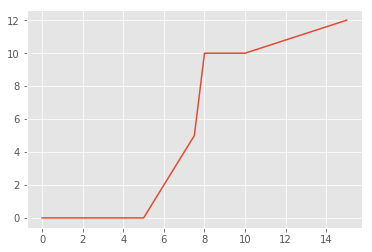

In [8]:
start_x=[0,5,7.5,8,10,15]
start_y=[0,0,5,10,10,12]
path = compute_path_from_wp(start_x,start_y)

print(np.shape(path))

plt.plot(path[0,:],path[1,:])
plt.show()

test cte

In [26]:
calc_target_index([0, 2, 0.75],path)

(1, -1.642756358806414)

mpc

In [20]:
# Define Objective function
def objective(u_hat,*args):
    """
    Computes objective function
    
    :param u_hat: array_like, input [v,w
                                     v,w
                                     ...]
    """
    
    #undo input flattening
    u_hat = u_hat.reshape(2, -1).T
    se = np.zeros(PRED_HZN) #squared_errors
    
    # Prediction
    for k in range(PRED_HZN):
        
        # Initialize state for prediction
        if k==0:
            q_hat0 = args[0]
        
        # Clamp control horizon
        elif k>CTRL_HZN:
            u_hat[k,:] = u_hat[CTRL_HZN,:]

        ts_hat = [delta_t_hat*(k),delta_t_hat*(k+1)]
        
        #DEBUG
#         print("k : {}".format(k))
#         print("q_hat0 : {}".format(q_hat0))
#         print("ts : {}".format(ts_hat))
#         print("u_hat : {}".format(u_hat[k,:]))
        
        q_hat = odeint(kinematics_model,q_hat0,ts_hat,args=(u_hat[k,:],))
        
#        print(q_hat)
        
        q_hat0 = q_hat[-1,:]

        # Squared Error calculation
        _,cte = calc_target_index(q_hat[-1,:],path)
#        print(cte)
        if k >0:
            delta_u_hat = np.sum(u_hat[k,:]-u_hat[k-1,:])
        else:
            delta_u_hat = 0
        #delta_u_hat=np.sum(np.subtract([u_hat[2*k],u_hat[2*k+1]],[u_hat[2*(k-1)],u_hat[2*(k-1)+1]]))
        se[k] = 20 * (cte)**2 + 15 * (delta_u_hat)**2

    # Sum of Squared Error calculation
    obj = np.sum(se[1:])
    return obj

TODO: add heading error

test optimization

In [32]:
#PARAMS
v=1.5
vb=0.5
wb=0.5

# Define horizons
PRED_HZN = 20 # Prediction Horizon
CTRL_HZN = 10  # Control Horizon

delta_t_hat = 0.25 #time step

In [33]:
q=np.array([[0,0.5],[0,0.4],[0,0.2]])

u_hat0 = np.zeros((PRED_HZN,2))
u_hat0[:,0]=v
u_hat0[:,1]=0.1
u_hat0=u_hat0.flatten("F")

bnds=((v-2*vb,v+vb),)
for i in range (PRED_HZN-1):
    bnds=bnds+((v-2*vb,v+vb),)
    
bnds=bnds+((-wb,wb),)
for i in range (PRED_HZN-1):
    bnds=bnds+((-wb,wb),)

# print(u_hat0)
# print(u_hat0.reshape(2, -1).T)

start = time.time()

solution = minimize(objective,u_hat0,args=(q[:,-1],),method='SLSQP',bounds=bnds,options={'maxiter':50})

end = time.time()

print(solution)
print("time elapsed: {}".format(end-start))

/home/marcello/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


     fun: 36.02837407165175
     jac: array([-2.19157696e+00, -3.22256088e-02,  1.18650579e+00, -4.04749918e+00,
        1.49658680e-01,  6.93027973e-01, -8.36541653e-01, -2.46588659e+00,
        1.18037081e+00,  1.26046467e+00, -4.76961613e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -2.14655476e+01, -2.45364900e+01, -2.71573195e+01, -3.44248009e+01,
       -3.15746927e+01, -3.04034195e+01, -3.05026488e+01, -2.93093610e+01,
       -2.17690802e+01, -1.74863310e+01, -8.52382469e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 1034
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([ 1.36094105,  1.44124498,  1.49189215,  1.4944542 ,  1.48896953,
        1.4

check what the optimizer returns

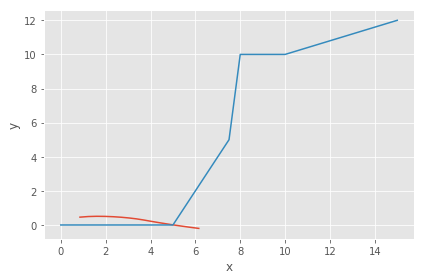

In [34]:
u=solution.x.reshape(2,-1).T
x=[]
y=[]
theta=[]
q0=[0.5,0.4,0.2]

#simulate q for optimized u_hat
def step(q0,u,delta):
    """
    steps the simulated vehicle
    """
    
    # span for next time step
    tspan = [delta*0,delta*1]
    # solve for next step
    q_t = odeint(kinematics_model,q0,tspan,args=(u,))
    
    return q_t[1]

for i in range(1,np.shape(u)[0]):
    
    # step simulation of t
    q_t = step(q0,u[i,:],delta_t_hat)
    
    # store solution for plotting
    x.append(q_t[0])
    y.append(q_t[1])
    theta.append(q_t[2])
    
    # next initial condition
    q0 = q_t
    
plt.plot(x,y)
plt.plot(path[0,:],path[1,:])
plt.ylabel('y')
plt.xlabel('x')

plt.tight_layout()
plt.show()

compute MPC on the whole path

In [185]:
# Initialize state
# q=[x1,     x2,     ..., xn
#    y1,     y2,     ..., yn
#    theta1, theta2, ..., thetan]

q=np.array([0,0.5,0.15]).reshape(3,-1)

# Initialize input for prediction horizon
# u=[v1,v2,...,vp
#    w1,w2,...,wp]

# Initial guess 
# u_hat0=[v1,v2,..vp,w1,w2,...,wp]
# uhat0 -> u_hat=optimize(obj,u_hat0)

u_hat0 = np.zeros((PRED_HZN,2))
u_hat0[:,0]=v
u_hat0[:,1]=0.01
u_hat0=u_hat0.flatten("F")

# Optimization Bounds
# bnds=((v1_min,v1_max),...,(vp_min,vp_max),(w1_min,w1_max),...,(wp_min,wp_max))

bnds=((v-2*vb,v+vb),)
for i in range (1,PRED_HZN):
    bnds=bnds+((v-2*vb,v+vb),)
    
bnds=bnds+((-wb,wb),)
for i in range (1,PRED_HZN):
    bnds=bnds+((-wb,wb),)

#while np.sum(np.abs(q[-1,0:2]-path[-1,0:2]))>0.1:
for i in range(110):   
    
    start = time.time()
    
    #MPC LOOP
    u_hat = minimize(objective,
                     u_hat0,
                     args=(q[:,-1],),
                     method='SLSQP',
                     bounds=bnds,
                     options={'maxiter':100}
                    ).x
    
    end = time.time()
    #print("iter:1 time elapsed: {}".format(end-start))
    
#     print("u_hat0 {}".format(np.shape(u_hat0)))
#     print("u_hat {}".format(np.shape(u_hat)))
#     print("bounds {}".format(np.shape(bnds)))
    
    # "move" vehicle
    q_next = odeint(kinematics_model,
                    q[:,-1],                             # q(t)
                    [0,delta_t_hat],                     # 
                    args=([u_hat[0],u_hat[PRED_HZN]],) # v,w
                   )
    
    q = np.hstack((q,q_next[-1,:].reshape(3,-1)))
    
    # next initial condition
    u_hat0=u_hat

    

/home/marcello/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


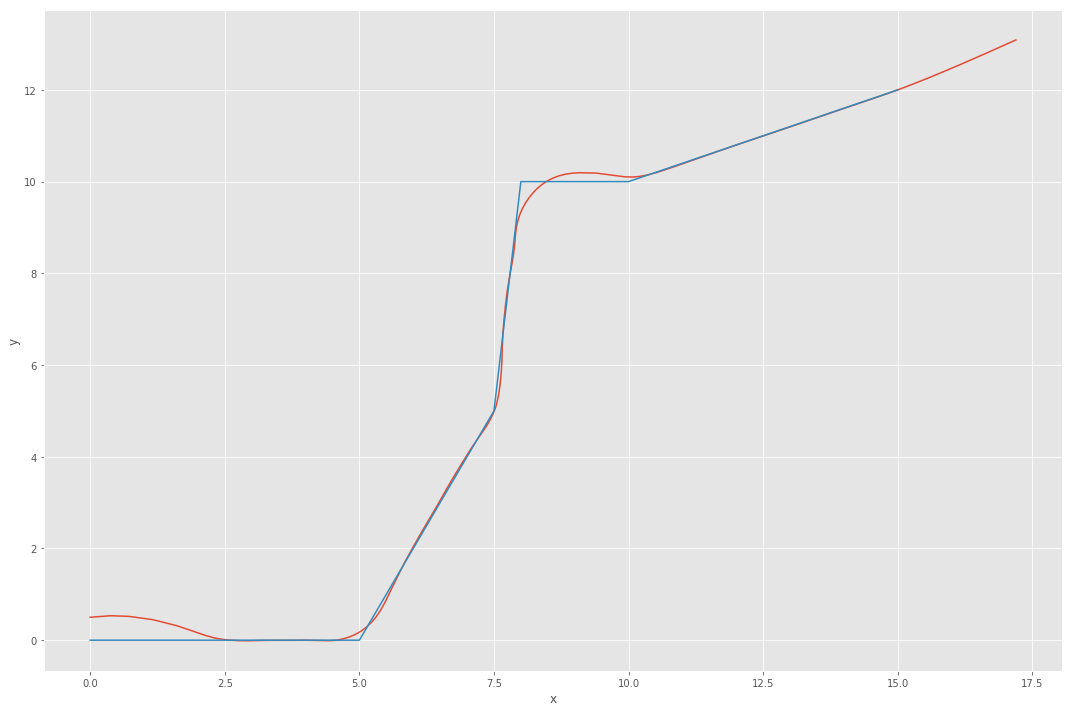

In [186]:
plt.figure(figsize=(15,10))

plt.plot(q[0,:],q[1,:])
plt.plot(path[0,:],path[1,:])
plt.ylabel('y')
plt.xlabel('x')

plt.tight_layout()

plt.show()